<a href="https://colab.research.google.com/github/Csillag61/AIX360/blob/master/restaurant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/pandas

/content/drive/MyDrive/Colab Notebooks/pandas


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Extract and Merge Data (No ORM—Just sqlite3)

In [15]:
import sqlite3

conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/pandas/db.sqlite3")


In [12]:
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Available tables:", tables)

conn.close()

Available tables: [('sqlite_sequence',), ('restaurant_orderitem',), ('restaurant_product',), ('restaurant_order',)]


In [21]:
import sqlite3

conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/pandas/db.sqlite3")
cursor = conn.cursor()

# Show columns for the restaurant_order table
cursor.execute("PRAGMA table_info(restaurant_order);")
columns = cursor.fetchall()

# Print column names nicely
print("Columns in restaurant_order table:")
for col in columns:
    print(f"- {col[1]} ({col[2]})")

conn.close()

Columns in restaurant_order table:
- id (INTEGER)
- datetime (datetime)


In [23]:
import sqlite3

conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/pandas/db.sqlite3")
cursor = conn.cursor()

# Show columns for the restaurant_order table
cursor.execute("PRAGMA table_info(restaurant_product);")
columns = cursor.fetchall()

# Print column names nicely
print("Columns in restaurant_product table:")
for col in columns:
    print(f"- {col[1]} ({col[2]})")

conn.close()

Columns in restaurant_product table:
- id (INTEGER)
- price (decimal)
- name (varchar(100))


In [32]:
import sqlite3

conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/pandas/db.sqlite3")
cursor = conn.cursor()

# Show columns for the restaurant_order table
cursor.execute("PRAGMA table_info(restaurant_orderitem);")
columns = cursor.fetchall()

# Print column names nicely
print("Columns in restaurant_orderitem table:")
for col in columns:
    print(f"- {col[1]} ({col[2]})")

conn.close()

Columns in restaurant_orderitem table:
- id (INTEGER)
- quantity (INTEGER)
- order_id (bigint)
- product_id (bigint)


In [33]:
conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/pandas/db.sqlite3")

In [34]:
query = """
SELECT
    o.id AS order_id,
    o.datetime,
    p.id AS product_id,
    p.name AS product_name,
    p.price,
    oi.quantity,
    (p.price * oi.quantity) AS revenue
FROM restaurant_orderitem oi
JOIN restaurant_order o ON oi.order_id = o.id
JOIN restaurant_product p ON oi.product_id = p.id
"""


In [35]:
df = pd.read_sql_query(query, conn)
df.to_csv("data.csv", index=False)
df = pd.read_csv("data.csv")
print(f"Row count: {len(df)}")

conn.close()

Row count: 74818


In [36]:
df.head()

,order_id,datetime,product_id,product_name,price,quantity,revenue
0,1,2019-08-03 20:25:00,6,Plain Papadum,0.80,2,1.60
1,1,2019-08-03 20:25:00,240,King Prawn Balti,12.95,1,12.95
2,1,2019-08-03 20:25:00,19,Garlic Naan,2.95,1,2.95
3,1,2019-08-03 20:25:00,36,Mushroom Rice,3.95,1,3.95
4,1,2019-08-03 20:25:00,111,Paneer Tikka Masala,8.95,1,8.95


2. Top-10 Most Popular Products by Quantity

In [37]:
top_quantity = df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)
top_quantity

,quantity
product_name,
Plain Papadum,10648
Pilau Rice,6367
Plain Naan,4983
Garlic Naan,3318
Plain Rice,2964
Onion Bhajee,2749
Mango Chutney,2504
Chicken Tikka Masala,2473
Chapati,1935


Text(0, 0.5, 'Total Quantity')

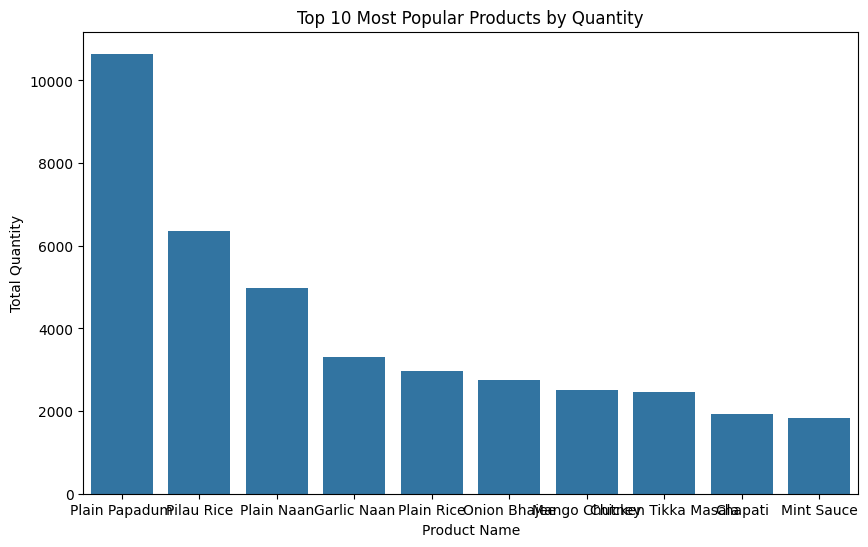

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_quantity.index, y=top_quantity.values)
plt.title('Top 10 Most Popular Products by Quantity')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity')

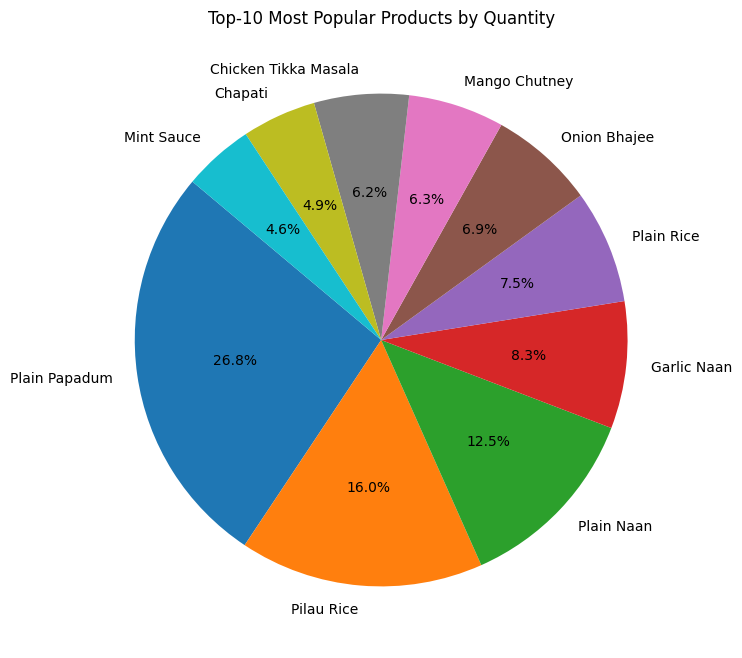

In [39]:
plt.figure(figsize=(8, 8))
top_quantity.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Top-10 Most Popular Products by Quantity")
plt.ylabel("")
plt.show()

3. Top-10 Most Profitable Products by Revenue

In [40]:
top_revenue = df.groupby('product_name')['revenue'].sum().sort_values(ascending=False).head(10)
top_revenue

,revenue
product_name,
Chicken Tikka Masala,22133.35
Pilau Rice,18782.65
Plain Naan,12955.80
Korma,12261.50
Bombay Aloo,10894.45
Onion Bhajee,10858.55
Butter Chicken,10626.60
Garlic Naan,9788.10
Korma - Chicken,9764.45


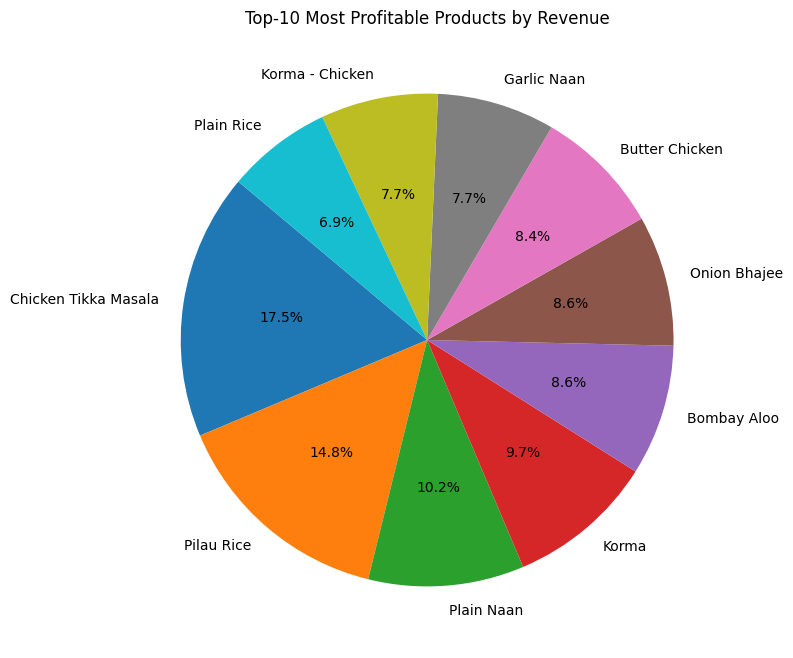

In [41]:
plt.figure(figsize=(8, 8))
top_revenue.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Top-10 Most Profitable Products by Revenue")
plt.ylabel("")
plt.show()

In [42]:
# Top 10 by quantity
top_qty = (
    df.groupby('product_name')['quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'quantity': 'total_quantity'})
)

# Top 10 by revenue
top_rev = (
    df.groupby('product_name')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'revenue': 'total_revenue'})
)

# Merge on product name to find overlaps
merged_top = pd.merge(top_qty, top_rev, on='product_name', how='outer').fillna(0)
merged_top['in_top_both'] = (merged_top['total_quantity'] > 0) & (merged_top['total_revenue'] > 0)

print(merged_top.sort_values(by='in_top_both', ascending=False))


            product_name  total_quantity  total_revenue  in_top_both
3   Chicken Tikka Masala          2473.0       22133.35         True
4            Garlic Naan          3318.0        9788.10         True
9           Onion Bhajee          2749.0       10858.55         True
10            Pilau Rice          6367.0       18782.65         True
11            Plain Naan          4983.0       12955.80         True
13            Plain Rice          2964.0        8743.80         True
0            Bombay Aloo             0.0       10894.45        False
1         Butter Chicken             0.0       10626.60        False
2                Chapati          1935.0           0.00        False
5                  Korma             0.0       12261.50        False
6        Korma - Chicken             0.0        9764.45        False
7          Mango Chutney          2504.0           0.00        False
8             Mint Sauce          1840.0           0.00        False
12         Plain Papadum         1

4. Revenue Analysis by Hour

Text(0, 0.5, 'Total Revenue')

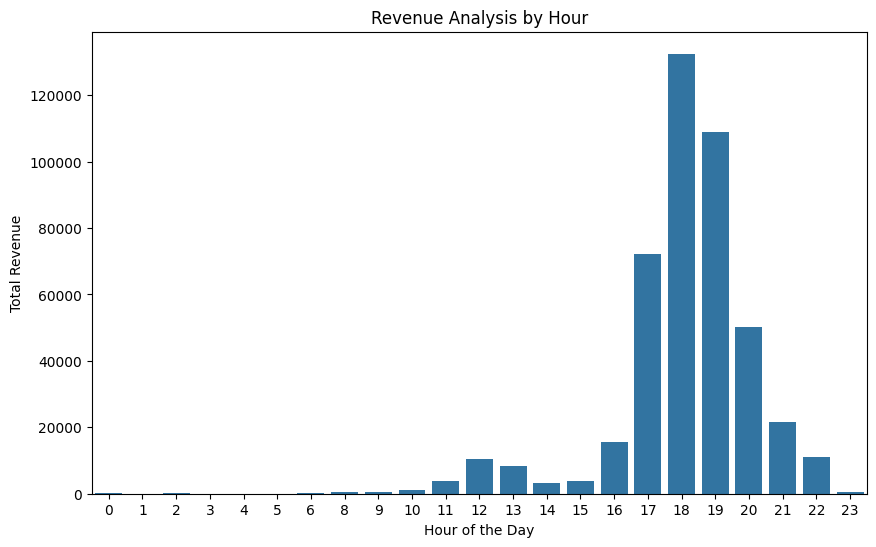

In [46]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour

hourly_revenue = df.groupby('hour')['revenue'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='revenue', data=hourly_revenue)
plt.title('Revenue Analysis by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue')


5. Revenue Analysis by Day of the Week

In [47]:
df['weekday'] = df['datetime'].dt.day_name()

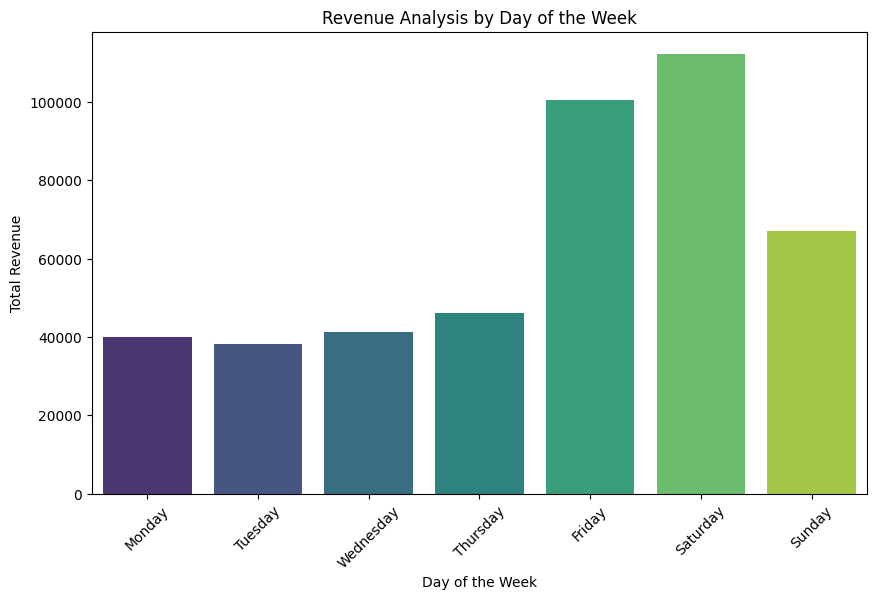

In [49]:
weekday_revenue = (
    df.groupby('weekday')['revenue']
    .sum()
    .reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='weekday',
    y='revenue',
    data=weekday_revenue,
    palette='viridis',
    hue='weekday',
    legend=False
    )
plt.title('Revenue Analysis by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()